<a href="https://colab.research.google.com/github/SusilPatro/Analytics_Redshift/blob/main/Copy_of_MHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP Approach for MHD**

In [1]:
import spacy
sp = spacy.load("en_core_web_sm")
import os
import csv
import numpy as np
import pandas as pd
import re
import nltk
import gensim
import matplotlib.pyplot as plt
import time

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline as imbpipeline
#from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score



from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator

from IPython.display import display, HTML
from scipy import spatial

from statistics import mean
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
approved_list = ["adhd_2018_features_tfidf_256.csv",
                "bpd_2019_features_tfidf_256.csv",
                "schizophrenia_2019_features_tfidf_256.csv",
               # "bipolarreddit_2018_features_tfidf_256.csv",
                "anxiety_2019_features_tfidf_256.csv",
                "depression_2018_features_tfidf_256.csv",
                "EDAnonymous_2019_features_tfidf_256.csv"]

posts_dict = {}
for dirname, _, filenames in os.walk('/content/'):

    for filename in filenames:

        if filename in approved_list:

            curr_df = pd.read_csv('/content/' + filename)
            #print(curr_df.columns)
            #print(curr_df.post)
            #print(len(list(curr_df.post)))
            disorder = filename.split("_")[0]
            print("DISORDER: " + disorder)
            if disorder == "bipolarreddit":
                disorder = "bipolar"
            elif disorder == "EDAnonymous":
                disorder = "eating_disorder"
            posts_dict[disorder] = list(curr_df.post)

print("FINISHED LOOPING THROUGH FILES")
for k in posts_dict.keys():
    print(f"Key: {k}\nLength: {len(posts_dict[k])}")


df = pd.DataFrame(columns=['disorder', 'post'])
count = 0
for k in posts_dict.keys():
    for post in posts_dict[k]:
        df.loc[count] = [k, post]
        count += 1
print(df.shape)



DISORDER: schizophrenia
DISORDER: anxiety
DISORDER: adhd
DISORDER: bpd
DISORDER: EDAnonymous
DISORDER: depression
FINISHED LOOPING THROUGH FILES
Key: schizophrenia
Length: 1550
Key: anxiety
Length: 13213
Key: adhd
Length: 5110
Key: bpd
Length: 4988
Key: eating_disorder
Length: 2588
Key: depression
Length: 24535
(51984, 2)


In [3]:
df.head()

,disorder,post
0,schizophrenia,help me understand why I 'excite' my schizophr...
1,schizophrenia,"Supposed to see psychiatrist, worried I was re..."
2,schizophrenia,Should I check myself into inpatient? Can't tr...
3,schizophrenia,anyone know where/how to apply for gov aid? (U...
4,schizophrenia,How much does inpatient psychiatric care cost?...


In [4]:
df['disorder'].value_counts()

disorder
depression         24535
anxiety            13213
adhd                5110
bpd                 4988
eating_disorder     2588
schizophrenia       1550
Name: count, dtype: int64

In [5]:
def preprocess_data(text: str) -> str:
    ''' The function to remove punctuation,
    stopwords and apply stemming'''
    stop = stopwords.words('english')
    porter = PorterStemmer()
    words = re.sub("[^a-zA-Z]", " ", text)
    words = [word.lower() for word in text.split() if word.lower() not in stop]
    words = [porter.stem(word) for word in words]
    return " ".join(words)

In [6]:
def splitting_data(data: pd.DataFrame):
    ''' Function to split data on train and test set '''
    X = df['post']
    y = df['disorder']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def get_models(X_train, X_test, y_train, y_test)-> pd.DataFrame:
  models = pd.DataFrame()
  classifiers = [
        LogisticRegression(max_iter = 1000),
        LinearSVC(),
        MultinomialNB(),
        RandomForestClassifier(n_estimators=50),
        GradientBoostingClassifier(n_estimators=50),
        ]

  for classifier in classifiers:
    try:
            pipeline = Pipeline(steps=[
                    ('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    #('smote', SMOTE()),
                    ('classifier', classifier)
            ])
            pipeline.fit(X_train, y_train)
            score = pipeline.score(X_test, y_test)
            param_dict = {
                      'Model': classifier.__class__.__name__,
                      'Score': score
            }
            #models = models.append(pd.DataFrame(param_dict, index=[0]))
            new_row = pd.DataFrame.from_dict(param_dict, orient='index')
            #new_row.columns = ['Model', 'score']
            models = pd.concat([models, new_row], ignore_index=True)
    except Exception as e:
            print(f"Error occurred while fitting {classifier.__class__.__name__}: {str(e)}")

  models.reset_index(drop=True, inplace=True)
  #models_sorted = models.sort_values(by='Score', ascending=False)
  print(models)
  return models

In [8]:
df['post'] = df['post'].apply(preprocess_data)
X_train, X_test, y_train, y_test = splitting_data(df)


In [13]:
get_models(X_train, X_test, y_train, y_test)

                            0
0          LogisticRegression
1                    0.841951
2                   LinearSVC
3                    0.853801
4               MultinomialNB
5                    0.600723
6      RandomForestClassifier
7                    0.749307
8  GradientBoostingClassifier
9                    0.810018


,0
0,LogisticRegression
1,0.841951
2,LinearSVC
3,0.853801
4,MultinomialNB
5,0.600723
6,RandomForestClassifier
7,0.749307
8,GradientBoostingClassifier
9,0.810018


**Visualization**

In [9]:
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

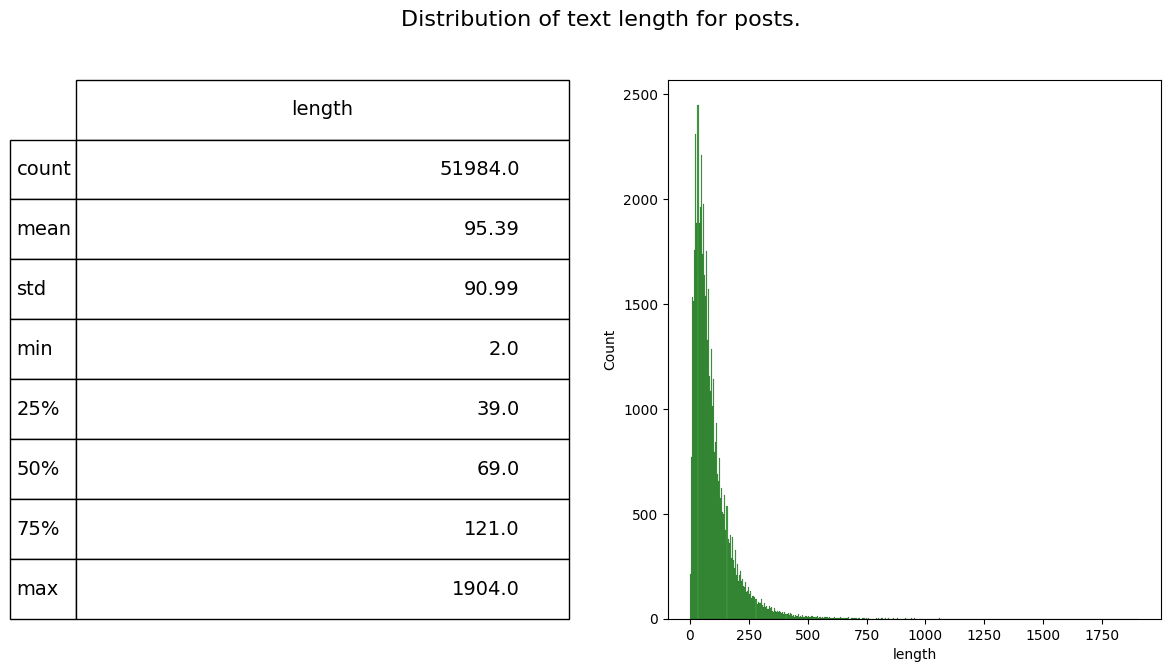

In [16]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.post.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for posts.', fontsize=16)

plt.show()

<Axes: xlabel='disorder', ylabel='count'>

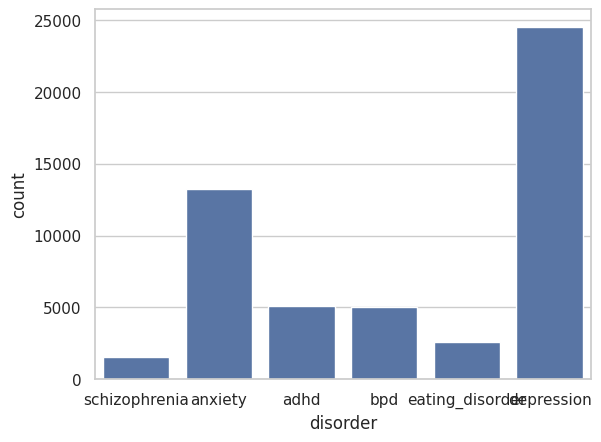

In [18]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["disorder"])

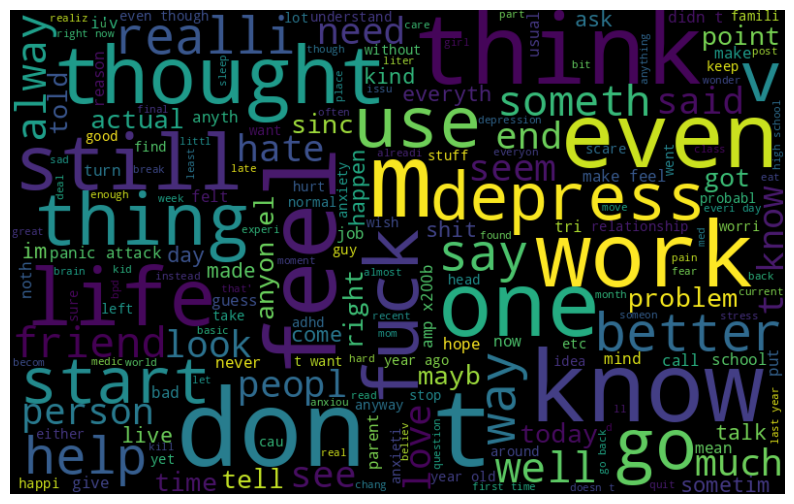

In [20]:
from wordcloud import WordCloud
from wordcloud import WordCloud,ImageColorGenerator
normal_words =' '.join([text for text in df['post']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

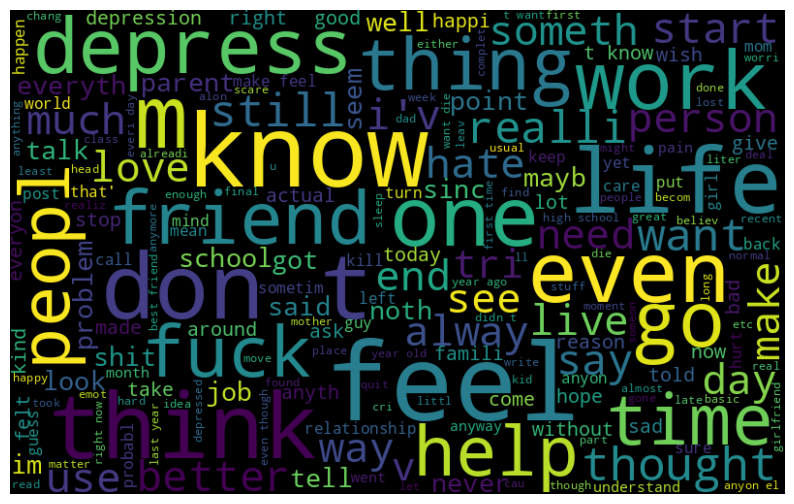

In [23]:
normal_words =' '.join([text for text in df['post'][df['disorder'] == 'depression']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

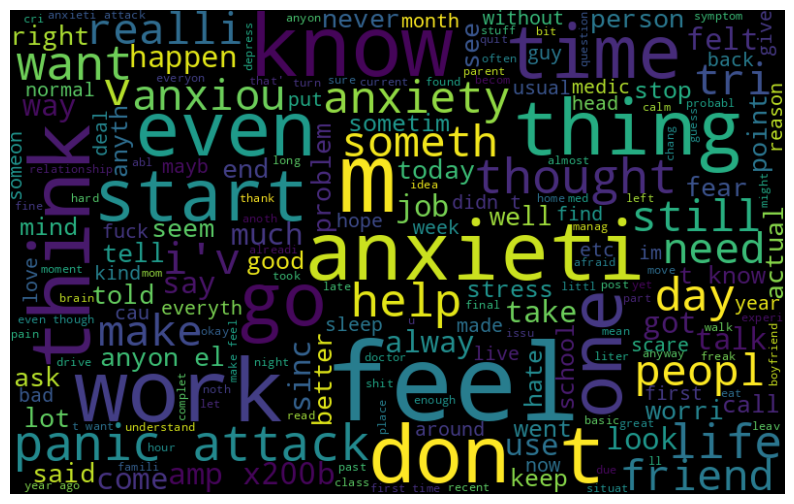

In [24]:
normal_words =' '.join([text for text in df['post'][df['disorder'] == 'anxiety']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

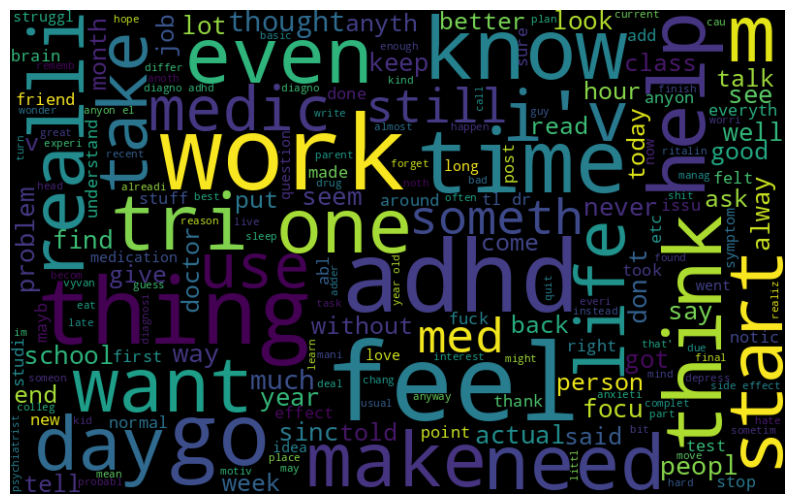

In [25]:
normal_words =' '.join([text for text in df['post'][df['disorder'] == 'adhd']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

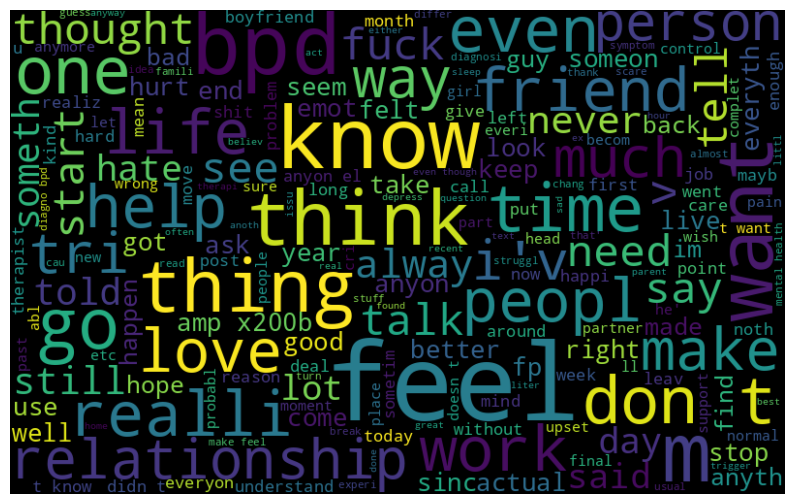

In [26]:
normal_words =' '.join([text for text in df['post'][df['disorder'] == 'bpd']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

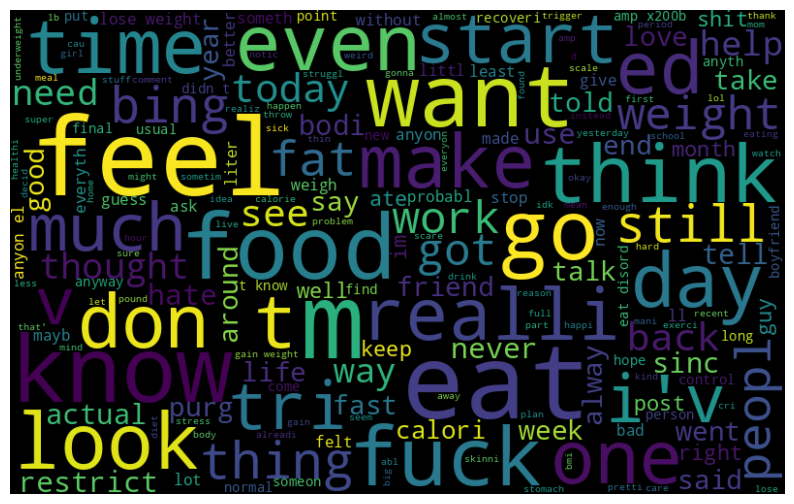

In [27]:
normal_words =' '.join([text for text in df['post'][df['disorder'] == 'eating_disorder']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

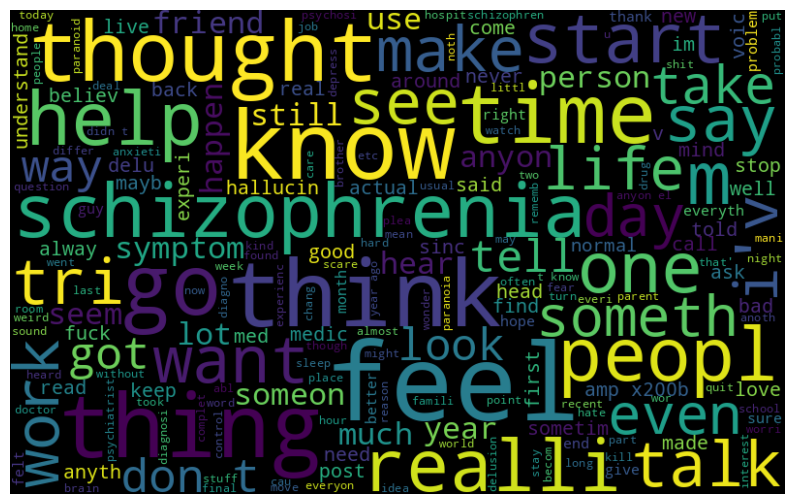

In [28]:
normal_words =' '.join([text for text in df['post'][df['disorder'] == 'schizophrenia']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Applying N-gram**

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df["post"],df["disorder"], test_size = 0.25, random_state = 42)
count_vect = CountVectorizer(ngram_range=(1, 2))
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

print (x_train_tfidf.shape,x_test_tfidf.shape, y_train.shape, y_test.shape)

(38988, 1333729) (12996, 1333729) (38988,) (12996,)


**## Machine Learning Models**

**Logistic Regression**

In [11]:
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lr.fit(x_train_tfidf, y_train)
y_pred1 = lr.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred1)))
print(classification_report(y_test, y_pred1))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Accuracy: 0.8414127423822715
                 precision    recall  f1-score   support

           adhd       0.93      0.77      0.84      1258
        anxiety       0.85      0.83      0.84      3317
            bpd       0.91      0.57      0.70      1192
     depression       0.81      0.96      0.88      6201
eating_disorder       0.90      0.72      0.80       632
  schizophrenia       0.97      0.38      0.55       396

       accuracy                           0.84     12996
      macro avg       0.90      0.70      0.77     12996
   weighted avg       0.85      0.84      0.83     12996



In [13]:
from sklearn.model_selection import cross_val_score, cross_val_predict

scores = cross_val_score(lr, x_train_tfidf,y_train, cv=10)
print(accuracy_score(y_test,y_pred1))
print ("Cross-validated scores:", scores)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likel

0.8414127423822715
Cross-validated scores: [0.82713516 0.82277507 0.82969992 0.82303155 0.82072326 0.82867402
 0.81482431 0.82764811 0.83273474 0.82529502]


In [15]:
import joblib
joblib.dump(lr, 'Text_LR.pkl')
#model = joblib.load('Text_LR.pkl')

['Text_LR.pkl']

**Support Vector Machine**

In [16]:
svc = LinearSVC()
svc.fit(x_train_tfidf, y_train)
y_pred2 = svc.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred2)))
print(classification_report(y_test, y_pred2))

Accuracy: 0.8588796552785473
                 precision    recall  f1-score   support

           adhd       0.92      0.82      0.87      1258
        anxiety       0.86      0.84      0.85      3317
            bpd       0.91      0.62      0.74      1192
     depression       0.84      0.95      0.89      6201
eating_disorder       0.91      0.82      0.86       632
  schizophrenia       0.92      0.52      0.67       396

       accuracy                           0.86     12996
      macro avg       0.89      0.76      0.81     12996
   weighted avg       0.86      0.86      0.85     12996



In [17]:
scores = cross_val_score(svc, x_train_tfidf,y_train, cv=10)
print(accuracy_score(y_test,y_pred2))
print ("Cross-validated scores:", scores)

0.8588796552785473
Cross-validated scores: [0.84790972 0.84329315 0.8481662  0.84329315 0.84021544 0.84893562
 0.83406002 0.84534496 0.8509492  0.84915341]


In [18]:
joblib.dump(svc, 'Text_SVM.pkl')

['Text_SVM.pkl']

**Naive Bayes (Multinomial)**

In [19]:
mnb = MultinomialNB()
mnb.fit(x_train_tfidf, y_train)
y_pred3 = mnb.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred3)))
print(classification_report(y_test, y_pred3))

Accuracy: 0.4943059402893198


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

           adhd       0.00      0.00      0.00      1258
        anxiety       0.97      0.07      0.13      3317
            bpd       0.00      0.00      0.00      1192
     depression       0.49      1.00      0.65      6201
eating_disorder       0.00      0.00      0.00       632
  schizophrenia       0.00      0.00      0.00       396

       accuracy                           0.49     12996
      macro avg       0.24      0.18      0.13     12996
   weighted avg       0.48      0.49      0.34     12996



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
scores = cross_val_score(mnb, x_train_tfidf,y_train, cv=10)
print(accuracy_score(y_test,y_pred3))
print ("Cross-validated scores:", scores)

0.4943059402893198
Cross-validated scores: [0.48909977 0.48756091 0.48499615 0.48525263 0.48525263 0.48756091
 0.49038215 0.4855091  0.48178553 0.48819908]


**Random Forest**

In [21]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, class_weight='balanced')
rfc.fit(x_train_tfidf,y_train)
y_pred4 = rfc.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred4)))
print(classification_report(y_test, y_pred4))

Accuracy: 0.7583102493074793
                 precision    recall  f1-score   support

           adhd       0.73      0.83      0.78      1258
        anxiety       0.83      0.75      0.79      3317
            bpd       0.63      0.67      0.65      1192
     depression       0.88      0.76      0.81      6201
eating_disorder       0.39      0.94      0.55       632
  schizophrenia       0.54      0.60      0.56       396

       accuracy                           0.76     12996
      macro avg       0.67      0.76      0.69     12996
   weighted avg       0.80      0.76      0.77     12996



In [22]:
scores = cross_val_score(rfc, x_train_tfidf,y_train, cv=10)
print(accuracy_score(y_test,y_pred4))
print ("Cross-validated scores:", scores)

0.7583102493074793
Cross-validated scores: [0.76122083 0.73531675 0.75198769 0.7432675  0.7348038  0.74583226
 0.73275199 0.74993588 0.74781939 0.74499743]


**GradientBoostingClassifier**

In [24]:
gbc = GradientBoostingClassifier(n_estimators=100, max_features=1.0, max_depth=4, random_state=1, verbose=1)
gbc.fit(x_train_tfidf, y_train)
y_pred5 = gbc.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred5))
print(classification_report(y_test, y_pred5))

      Iter       Train Loss   Remaining Time 
         1           1.1956           98.51m
         2           1.0940           96.45m
         3           1.0195           95.43m
         4           0.9621           93.49m
         5           0.9154           91.93m
         6           0.8773           90.48m
         7           0.8448           89.58m
         8           0.8168           88.46m
         9           0.7923           87.31m
        10           0.7711           86.28m
        20           0.6460           76.68m
        30           0.5824           66.89m
        40           0.5400           56.93m
        50           0.5065           46.98m
        60           0.4817           37.31m
        70           0.4609           27.82m
        80           0.4446           18.43m
        90           0.4290            9.16m
       100           0.4156            0.00s
0.8253308710372422
                 precision    recall  f1-score   support

           adhd       

In [ ]:
scores = cross_val_score(gbc, x_train_tfidf,y_train, cv=5)
print(accuracy_score(y_test,y_pred5))
print ("Cross-validated scores:", scores)

      Iter       Train Loss   Remaining Time 
         1           1.1946          621.40m
         2           1.0921          595.17m
         3           1.0189          580.26m
         4           0.9610          567.89m
         5           0.9145          559.87m
         6           0.8759          552.22m
         7           0.8433          544.39m
         8           0.8150          538.00m
         9           0.7905          531.28m


**Ensembler Classifier**

**Ensemble Classifier**

In [ ]:

mnb = MultinomialNB()
rfc= RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42)
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
svc = SVC(probability=True)
ec=VotingClassifier(estimators=[('Multinominal NB', mnb), ('Random Forest', rfc),('Logistic Regression',lr),('Support Vector Machine',svc)], voting='soft', weights=[1,2,3,4])
ec.fit(x_train_tfidf,y_train)
y_pred6 = ec.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred6))
print(classification_report(y_test, y_pred6))

**Prediction to verify**

In [ ]:
mc = count_vect.transform(["But what really set this movie apart for me was the way it integrated Chinese culture and mythology into the story. As a Chinese-American myself, it was incredibly meaningful to see my culture and heritage represented on the big screen in such a beautiful and authentic way. From the stunning visuals to the traditional music and dance, everything felt like it was done with care and respect."])
m = transformer.transform(mc)
y_pred = ec.predict(m)
print(y_pred)

Cross Validation Scores

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
scores = cross_val_score(ec, x_train_tfidf,y_train, cv=10)
print(accuracy_score(y_test,y_pred6))
print ("Cross-validated scores:", scores)

In [ ]:
import joblib
joblib.dump(ec, 'Text_Ensemble.pkl')
#model = joblib.load('Text_Ensemble.pkl')

**AdaBoost with Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=0)
abc= AdaBoostClassifier(base_estimator=rfc, learning_rate=0.2, n_estimators=100)
abc.fit(x_train_tfidf, y_train)
y_pred7= abc.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test, y_pred7)))
print(classification_report(y_test, y_pred7))

Cross Validation Scores

In [ ]:
scores = cross_val_score(abc, x_train_tfidf,y_train, cv=10)
print(accuracy_score(y_test,y_pred7))
print ("Cross-validated scores:", scores)

**Comparision Between ML Models**

In [ ]:
Comparison_unibi = pd.DataFrame({'Logistic Regression': [accuracy_score(y_test,y_pred1)*100,f1_score(y_test,y_pred1,average='macro')*100,recall_score(y_test, y_pred1,average='micro')*100,precision_score(y_test, y_pred1,average='micro')*100],
                            'SVM':[accuracy_score(y_test,y_pred2)*100,f1_score(y_test,y_pred2,average='macro')*100,recall_score(y_test, y_pred2,average='micro')*100,precision_score(y_test, y_pred2,average='micro')*100],
                           'Naive Bayes':[accuracy_score(y_test,y_pred3)*100,f1_score(y_test,y_pred3,average='macro')*100,recall_score(y_test, y_pred3,average='micro')*100,precision_score(y_test, y_pred3,average='micro')*100],
                           'Random Forest':[accuracy_score(y_test,y_pred4)*100,f1_score(y_test,y_pred4,average='macro')*100,recall_score(y_test, y_pred4,average='micro')*100,precision_score(y_test, y_pred4,average='micro')*100],
                           'GradientBoosting':[accuracy_score(y_test,y_pred5)*100,f1_score(y_test,y_pred5,average='macro')*100,recall_score(y_test, y_pred5,average='micro')*100,precision_score(y_test, y_pred5,average='micro')*100],
                           'Ensembled':[accuracy_score(y_test,y_pred6)*100,f1_score(y_test,y_pred6,average='macro')*100,recall_score(y_test, y_pred6,average='micro')*100,precision_score(y_test, y_pred6,average='micro')*100],
                           'Adaboost':[accuracy_score(y_test,y_pred7)*100,f1_score(y_test,y_pred7,average='macro')*100,recall_score(y_test, y_pred7,average='micro')*100,precision_score(y_test, y_pred7,average='micro')*100],

})

In [ ]:
print ('Comparison using uni-bi-gram(1,2)')
Comparison_unibi.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison_unibi.head()

**Deep Learning Models**

**SHAP and LIME**

In [ ]:
# importing lime
import lime
from lime import lime_tabular

In [ ]:
# creating an instance of the lime tabular explainer
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train_tfidf), feature_names=x_train_tfidf.columns,
            class_names=['1', '2', '3'], mode='classification')

In [ ]:
# obtaining the explanation
explanation = lime_explainer.explain_instance(data_row=x_test.iloc[1], predict_fn=model.predict_proba, top_labels=6, num_features=13)

# printing out the explanation
explanation.show_in_notebook()

Explainability Via SHAP

In [ ]:
# importing shap
import shap

In [ ]:
# instantiating a TreeExplainer object
explainer = shap.TreeExplainer(model)

In [ ]:
# obtaining shapely values of the data
shap_values = explainer.shap_values(x)

In [ ]:
# plotting the dependence of shapely values on alcohol
shap.dependence_plot('Alcohol', shap_values[0], x)

In [ ]:
# plotting the dependence of shapely values on all the features
shap.summary_plot(shap_values[0], x)

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
cwd = os.getcwd()

In [ ]:
for dirname, _, filenames in os.walk(cwd):
    for filename in filenames:
        if filename[-4:] == '.csv':
            print(os.path.join(dirname, filename))

/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv


In [ ]:
df1 = pd.read_csv("/content/prevalence-by-mental-and-substance-use-disorder.csv")
df2=pd.read_csv("/content/mental-and-substance-use-as-share-of-disease.csv")

In [ ]:
df1.head()

,Entity,Code,Year,Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent),Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent),Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent)
0,Afghanistan,AFG,1990,0.228979,0.721207,0.131001,4.835127,0.454202,5.125291,0.444036
1,Afghanistan,AFG,1991,0.228120,0.719952,0.126395,4.821765,0.447112,5.116306,0.444250
2,Afghanistan,AFG,1992,0.227328,0.718418,0.121832,4.801434,0.441190,5.106558,0.445501
3,Afghanistan,AFG,1993,0.226468,0.717452,0.117942,4.789363,0.435581,5.100328,0.445958
4,Afghanistan,AFG,1994,0.225567,0.717012,0.114547,4.784923,0.431822,5.099424,0.445779


In [ ]:
df2.head()

,Entity,Code,Year,DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)
0,Afghanistan,AFG,1990,1.696670
1,Afghanistan,AFG,1991,1.734281
2,Afghanistan,AFG,1992,1.791189
3,Afghanistan,AFG,1993,1.776779
4,Afghanistan,AFG,1994,1.712986


In [ ]:
data = pd.merge(df1, df2)
data.head()

,Entity,Code,Year,Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent),Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent),Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent),DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)
0,Afghanistan,AFG,1990,0.228979,0.721207,0.131001,4.835127,0.454202,5.125291,0.444036,1.696670
1,Afghanistan,AFG,1991,0.228120,0.719952,0.126395,4.821765,0.447112,5.116306,0.444250,1.734281
2,Afghanistan,AFG,1992,0.227328,0.718418,0.121832,4.801434,0.441190,5.106558,0.445501,1.791189
3,Afghanistan,AFG,1993,0.226468,0.717452,0.117942,4.789363,0.435581,5.100328,0.445958,1.776779
4,Afghanistan,AFG,1994,0.225567,0.717012,0.114547,4.784923,0.431822,5.099424,0.445779,1.712986


In [ ]:
data.drop('Code',axis=1,inplace=True)

In [ ]:
data.head()

,Entity,Year,Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent),Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent),Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent),DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)
0,Afghanistan,1990,0.228979,0.721207,0.131001,4.835127,0.454202,5.125291,0.444036,1.696670
1,Afghanistan,1991,0.228120,0.719952,0.126395,4.821765,0.447112,5.116306,0.444250,1.734281
2,Afghanistan,1992,0.227328,0.718418,0.121832,4.801434,0.441190,5.106558,0.445501,1.791189
3,Afghanistan,1993,0.226468,0.717452,0.117942,4.789363,0.435581,5.100328,0.445958,1.776779
4,Afghanistan,1994,0.225567,0.717012,0.114547,4.784923,0.431822,5.099424,0.445779,1.712986


In [ ]:
data = data.set_axis(['Country','Year','Schizophrenia', 'Bipolar_disorder', 'Eating_disorder','Anxiety','drug_usage','depression',
               'alcohol','mental_fitness'],
              axis='columns') #inplace true does not work here

In [ ]:
data1 = data.drop('Country',axis=1)

In [ ]:
data1.head()

,Year,Schizophrenia,Bipolar_disorder,Eating_disorder,Anxiety,drug_usage,depression,alcohol,mental_fitness
0,1990,0.228979,0.721207,0.131001,4.835127,0.454202,5.125291,0.444036,1.696670
1,1991,0.228120,0.719952,0.126395,4.821765,0.447112,5.116306,0.444250,1.734281
2,1992,0.227328,0.718418,0.121832,4.801434,0.441190,5.106558,0.445501,1.791189
3,1993,0.226468,0.717452,0.117942,4.789363,0.435581,5.100328,0.445958,1.776779
4,1994,0.225567,0.717012,0.114547,4.784923,0.431822,5.099424,0.445779,1.712986


Exploraory Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

[]

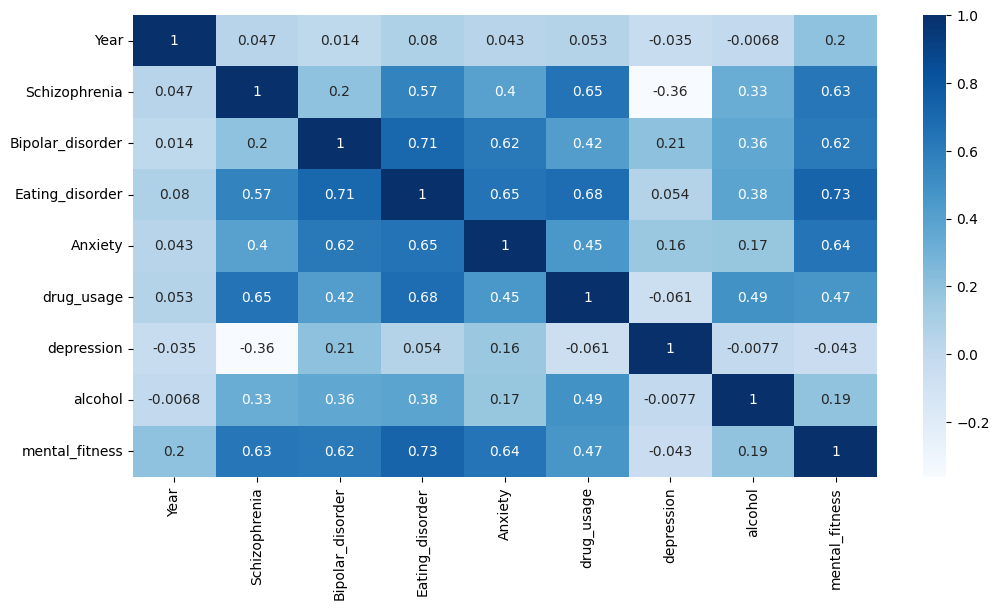

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(data1.corr(),annot=True,cmap='Blues')
plt.plot()

In [ ]:
data.head()

,Country,Year,Schizophrenia,Bipolar_disorder,Eating_disorder,Anxiety,drug_usage,depression,alcohol,mental_fitness
0,Afghanistan,1990,0.228979,0.721207,0.131001,4.835127,0.454202,5.125291,0.444036,1.696670
1,Afghanistan,1991,0.228120,0.719952,0.126395,4.821765,0.447112,5.116306,0.444250,1.734281
2,Afghanistan,1992,0.227328,0.718418,0.121832,4.801434,0.441190,5.106558,0.445501,1.791189
3,Afghanistan,1993,0.226468,0.717452,0.117942,4.789363,0.435581,5.100328,0.445958,1.776779
4,Afghanistan,1994,0.225567,0.717012,0.114547,4.784923,0.431822,5.099424,0.445779,1.712986


In [ ]:
data.size,data.shape

(68400, (6840, 10))

In [ ]:
df=data.copy()
df.head()

,Country,Year,Schizophrenia,Bipolar_disorder,Eating_disorder,Anxiety,drug_usage,depression,alcohol,mental_fitness
0,Afghanistan,1990,0.228979,0.721207,0.131001,4.835127,0.454202,5.125291,0.444036,1.696670
1,Afghanistan,1991,0.228120,0.719952,0.126395,4.821765,0.447112,5.116306,0.444250,1.734281
2,Afghanistan,1992,0.227328,0.718418,0.121832,4.801434,0.441190,5.106558,0.445501,1.791189
3,Afghanistan,1993,0.226468,0.717452,0.117942,4.789363,0.435581,5.100328,0.445958,1.776779
4,Afghanistan,1994,0.225567,0.717012,0.114547,4.784923,0.431822,5.099424,0.445779,1.712986


In [ ]:
from sklearn.preprocessing import LabelEncoder
l=LabelEncoder()
for i in df.columns:
    if df[i].dtype == 'object':
        df[i]=l.fit_transform(df[i])

In [ ]:
X = df.drop('mental_fitness',axis=1)
y = df['mental_fitness']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=2)

CNN - Neural Network implementation

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
ytrain.head()

839     6.056265
5815    4.583907
4405    6.861558
3813    5.304653
3442    6.985695
Name: mental_fitness, dtype: float64

In [ ]:
# Reshape data for CNN (add channel dimension)
X_train_cnn = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
X_test_cnn = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

# Define CNN model
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])


# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN model
cnn_model.fit(X_train_cnn, ytrain, epochs=10, batch_size=32, verbose=0)

# Evaluate the CNN model
cnn_predictions = cnn_model.predict(X_test_cnn).flatten()
cnn_mse = mean_squared_error(ytest, cnn_predictions)
print("CNN Regression MSE:", cnn_mse)


AttributeError: 'DataFrame' object has no attribute 'reshape'

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate regression metrics
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

NLP Approach

In [ ]:
import spacy
sp = spacy.load("en_core_web_sm")
import os
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from IPython.display import display, HTML
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import re
from statistics import mean
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
approved_list = ["adhd_2018_features_tfidf_256.csv",
                "bpd_2019_features_tfidf_256.csv",
                "schizophrenia_2019_features_tfidf_256.csv",
                "bipolarreddit_2018_features_tfidf_256.csv",
                "anxiety_2019_features_tfidf_256.csv",
                "depression_2018_features_tfidf_256.csv",
                "EDAnonymous_2019_features_tfidf_256.csv"]

posts_dict = {}
for dirname, _, filenames in os.walk('/content/'):

    for filename in filenames:
        if filename in approved_list:
            curr_df = pd.read_csv('/content/' + filename)
            #print(curr_df.columns)
            #print(curr_df.post)
            #print(len(list(curr_df.post)))
            disorder = filename.split("_")[0]
            print("DISORDER: " + disorder)
            if disorder == "bipolarreddit":
                disorder = "bipolar"
            elif disorder == "EDAnonymous":
                disorder = "eating_disorder"
            posts_dict[disorder] = list(curr_df.post)

print("FINISHED LOOPING THROUGH FILES")
for k in posts_dict.keys():
    print(f"Key: {k}\nLength: {len(posts_dict[k])}")


FINISHED LOOPING THROUGH FILES


In [ ]:
df = pd.DataFrame(columns=['disorder', 'post'])
count = 0
for k in posts_dict.keys():
    for post in posts_dict[k]:
        df.loc[count] = [k, post]
        count += 1
print(df.shape)

(0, 2)
